In [ ]:
# Only when running the notebook on Colab: clone the repo first...
!git clone https://github.com/rederoth/AICONic_ScanDy.git

In [1]:
import os
if os.getcwd().split("/")[-1] != "scr":
  # Colab: change to correct repo!
  os.chdir('AICONic_ScanDy/aiconic_scandy/src')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

from summary_plots import evaluate_all_obj, get_BDIR_per_frames, fovdur_vs_sacang, vonmises_kde

import visualization_eval_utils as veu

RES_DATA_DIR = '../../result_data'

## Base model

Base model: fd mean=389.88053170439525, median=331.9083615252009; sa mean=3.703562719456812, median=2.8102492711024767
Humans: fd mean=433.31408166433783, median=316.0; sa mean=3.400302870672175, median=2.904275816374561


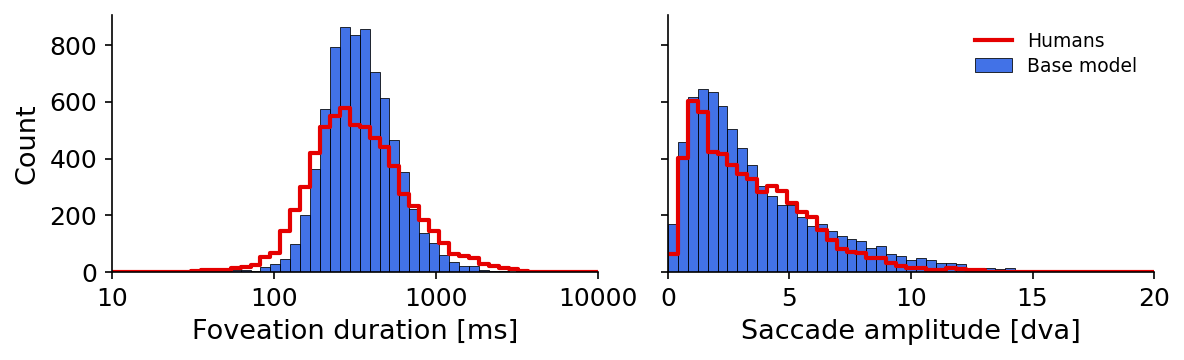

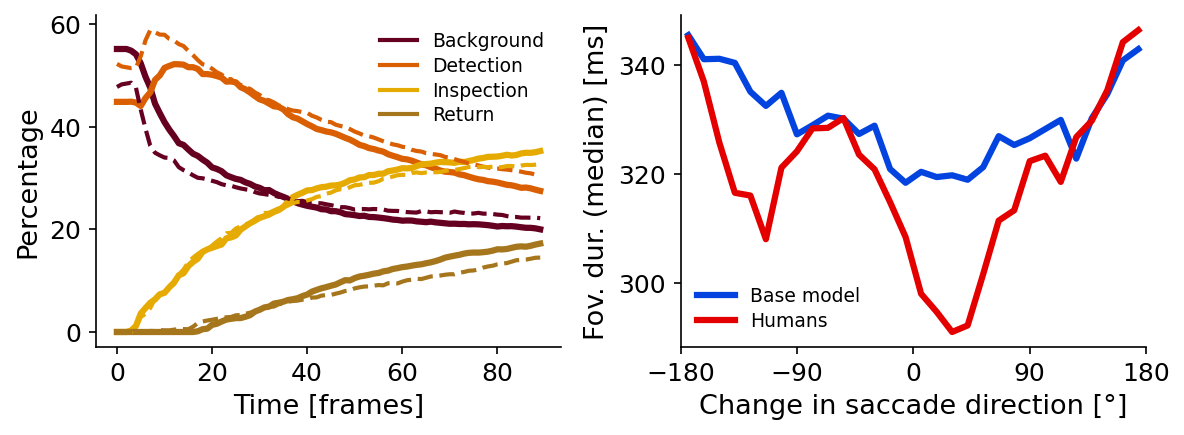

In [4]:
df_gt_all = pd.read_csv(os.path.join(RES_DATA_DIR, 'df_res_gt_fov_all.csv'), index_col=0)
base_test = "2024-05-24-18-45-25_TEST_base_task0.0_entropy0.5_dv4.0_sig0.4"
df_test_res = pd.read_csv(os.path.join(RES_DATA_DIR, base_test, 'df_res_fov.csv'), index_col=0)
df_test_gt = df_gt_all[df_gt_all["video"].isin(df_test_res["video"].unique())]
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(8, 2.5), sharey=True)
histtype = ["bars", "step"]
filltype = [True, False]
name = ["Base model", "Humans"]
colors=["xkcd:blue", "xkcd:red"]
dfs = [df_test_res, df_test_gt]
nbins = 50
for i, df in enumerate(dfs):
    amp_dva = df["sac_amp_dva"].dropna().values
    dur_ms = df["duration_ms"].dropna().values
    sns.histplot(data=np.log10(dur_ms), stat="count", ax=axs[0], bins=np.linspace(1, 4, nbins), color=colors[i], element=histtype[i], fill=filltype[i], lw=2, label=name[i])
    sns.histplot(data=amp_dva, kde=False, ax=axs[1], bins=np.linspace(0, 20, nbins), color=colors[i], element=histtype[i], fill=filltype[i], lw=2, label=name[i])
    print(f"{name[i]}: fd mean={np.mean(dur_ms)}, median={np.median(dur_ms)}; sa mean={np.mean(amp_dva)}, median={np.median(amp_dva)}")
    
axs[0].set_xlim([1, 4]); axs[0].set_xticks([1, 2, 3, 4])
axs[0].set_xticklabels([10, 100, 1000, 10000])
axs[0].tick_params(labelsize=12)
axs[0].set_xlabel('Foveation duration [ms]', size=13)
axs[0].set_ylabel('Count', size=13)
axs[1].set_xlabel('Saccade amplitude [dva]', size=13)
axs[1].set_xlim([0, 20])
axs[1].tick_params(labelsize=12)
axs[1].legend(labelspacing=0.3, prop={'size':9}, frameon=False)
sns.despine(fig)
fig.tight_layout()

veu.plot_emerging_stats(df_test_res, df_gt_all, summary_measure="median", ang_bins=30)

## Vary uncertainty contribution

6, 6
(2.5255370750784985, 0.29566705647227204) (2.012633780314372, 0, 1.6894791809273173)


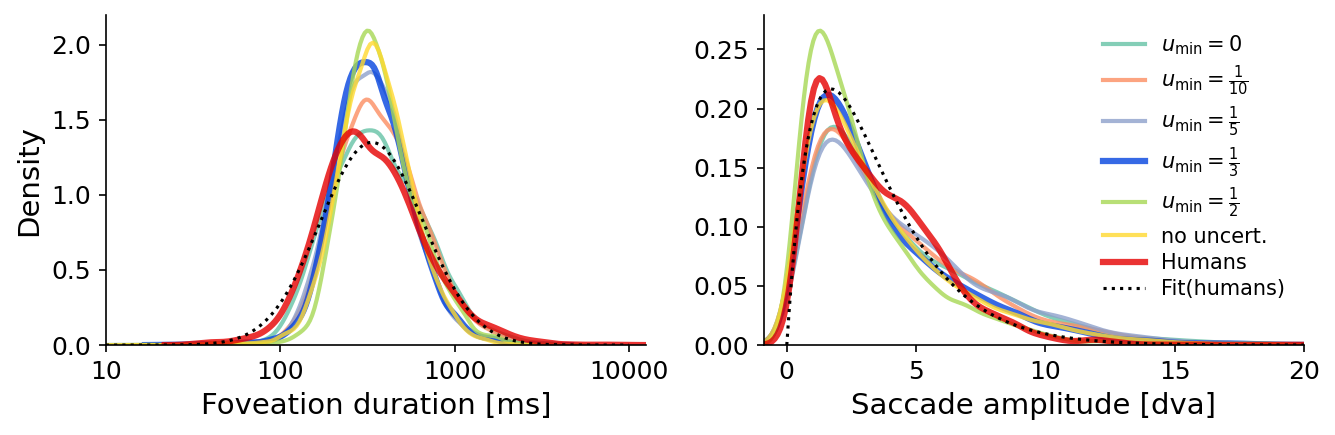

In [5]:
uncert_sets = ["2024-05-14-11-16-11_TEST_base_task0.0_entropy0.0_dv2.5_sig0.25",
               "2024-05-14-11-03-23_TEST_base_task0.0_entropy0.11_dv3.0_sig0.3", 
               "2024-05-22-14-22-57_TEST_base_task0.0_entropy0.25_dv3.5_sig0.4",
               "2024-05-24-18-45-25_TEST_base_task0.0_entropy0.5_dv4.0_sig0.4", 
               "2024-05-29-23-23-32_TEST_base_task0.0_entropy1.0_dv5.0_sig0.25",
               "2024-05-27-12-25-59_TEST_noUncert_task0.0_entropy0.5_dv3.0_sig0.3",
              ]
uncert_set_names = [r"$u_\mathrm{min}=0$", r"$u_\mathrm{min}=\frac{1}{10}$", r"$u_\mathrm{min}=\frac{1}{5}$", r"$u_\mathrm{min}=\frac{1}{3}$", r"$u_\mathrm{min}=\frac{1}{2}$", "no uncert."] #\n"+r"$(U_{const}=0.33)$
print(f"{len(uncert_sets)}, {len(uncert_set_names)}")
colors = sns.color_palette("Set2") # muted flare Set2 Blues

fig, axs = plt.subplots(1, 2, dpi=150, figsize=(9, 3), sharey=False)

for s_idx, s in enumerate(uncert_sets):
    df_eval = pd.read_csv(os.path.join(RES_DATA_DIR, s, 'df_res_fov.csv'), index_col=0)
    if s_idx == 3:
        lw=3; c = "xkcd:blue"
    else:
        lw=2; c = colors[s_idx]
    sns.kdeplot(np.log10(df_eval["duration_ms"].dropna().values), label=uncert_set_names[s_idx], color=c, lw=lw, alpha=0.8, ax=axs[0])
    sns.kdeplot(df_eval["sac_amp_dva"].dropna().values, label=uncert_set_names[s_idx], color=c, lw=lw, alpha=0.8, ax=axs[1])

df_gt = df_gt_all[df_gt_all["video"].isin(df_eval["video"].unique())]
gt_amp_dva = df_gt["sac_amp_dva"].dropna().values
gt_dur_ms = df_gt["duration_ms"].dropna().values
sns.kdeplot(np.log10(gt_dur_ms), label="Humans", color="xkcd:red", lw=3, alpha=0.8, ax=axs[0])
sns.kdeplot(gt_amp_dva, label="Humans", color="xkcd:red", lw=3, alpha=0.8, ax=axs[1])

ampX = np.linspace(0, 20, 200)
ampfit = stats.gamma.fit(gt_amp_dva, floc=0)
ampPDF = stats.gamma.pdf(ampX, *ampfit)

durX = np.linspace(1,4, 200)
durfit = stats.norm.fit(np.log10(gt_dur_ms))
durPDF = stats.norm.pdf(durX, *durfit)
print(durfit, ampfit)

axs[0].plot(durX, durPDF, color='k', ls=':')
axs[1].plot(ampX, ampPDF, color='k', ls=':', label='Fit(humans)')

axs[0].set_xticks([1,2,3,4])
axs[0].set_xlim([1, 4.1])
axs[0].set_xticklabels([10,100,1000,10000], size=14)
axs[0].tick_params(labelsize=12)
axs[0].set_xlabel('Foveation duration [ms]', size=14)
axs[0].set_ylabel('Density', size=14)
axs[1].set_ylabel("", size=14)
axs[1].set_xlabel('Saccade amplitude [dva]', size=14)
axs[1].tick_params(labelsize=12)
axs[1].set_xlim([-0.9, 20])
axs[1].legend(labelspacing=0.3, prop={'size':10}, frameon=False)

fig.tight_layout()
sns.despine(fig)
plt.show()

In [6]:
durfit_e = stats.norm.fit(np.log(dur_ms))
print(f"expected fov dur: {np.exp(durfit_e[0] + 0.5 * durfit_e[1]**2)}, report with basis e: {durfit_e}")
print(f"expected sac amp: {ampfit[0]*ampfit[2]}, alpha = {ampfit[0]}, beta = {1/ampfit[2]}")

expected fov dur: 422.8457089691535, report with basis e: (5.815264020879534, 0.6807985567224824)
expected sac amp: 3.400302870672175, alpha = 2.012633780314372, beta = 0.591898385780121


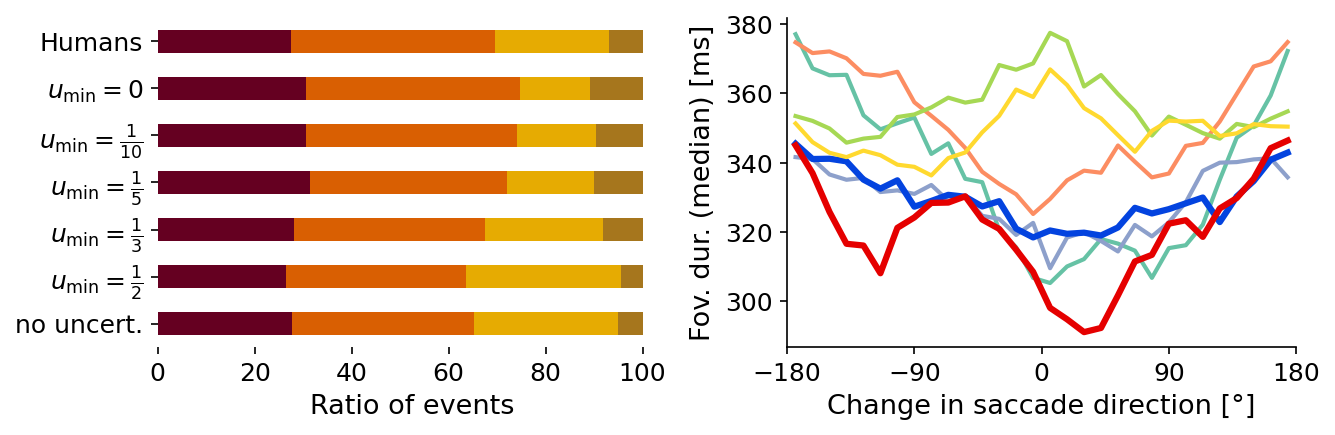

['2024-05-14-11-16-11_TEST_base_task0.0_entropy0.0_dv2.5_sig0.25',
 '2024-05-14-11-03-23_TEST_base_task0.0_entropy0.11_dv3.0_sig0.3',
 '2024-05-22-14-22-57_TEST_base_task0.0_entropy0.25_dv3.5_sig0.4',
 '2024-05-24-18-45-25_TEST_base_task0.0_entropy0.5_dv4.0_sig0.4',
 '2024-05-29-23-23-32_TEST_base_task0.0_entropy1.0_dv5.0_sig0.25',
 '2024-05-27-12-25-59_TEST_noUncert_task0.0_entropy0.5_dv3.0_sig0.3']

In [7]:
dircl = ["xkcd:maroon", sns.color_palette("Dark2")[1], sns.color_palette("Dark2")[5], sns.color_palette("Dark2")[6]]

summary_measure='median'; ang_bins=30; sma_ws=5; obj_maxframes=90
mean_fovcats_test = []

fig, axs = plt.subplots(1, 2, dpi=150, figsize=(9, 3), sharey=False)

for s_idx, s in enumerate(uncert_sets):
    df_eval = pd.read_csv(os.path.join(RES_DATA_DIR, s, 'df_res_fov.csv'), index_col=0)
    if s_idx == 3:
        lw=3; c = "xkcd:blue"
    else:
        lw=2; c = colors[s_idx]
    x_vals, all = fovdur_vs_sacang(df_eval, ang_bins, sma_ws, summary_measure)
    axs[1].plot(x_vals, all, color=c, label=uncert_set_names[s_idx], lw=lw)
    bdir_ratios = np.mean(get_BDIR_per_frames(df_eval, 90), axis=1)
    mean_fovcats_test.append(bdir_ratios)
    assert round(np.sum(bdir_ratios))==100

df_gt = df_gt_all[df_gt_all["video"].isin(df_eval["video"].unique())]
x_vals, all = fovdur_vs_sacang(df_gt, ang_bins, sma_ws, summary_measure)
axs[1].plot(x_vals, all, color="xkcd:red", label="Humans", lw=3)
gt_bdir_ratios = np.mean(get_BDIR_per_frames(df_gt, 90), axis=1)

mean_fovcats_test_r = mean_fovcats_test[::-1]
df_fovcats_test = pd.DataFrame(index=uncert_set_names[::-1] + ['Humans'], data= mean_fovcats_test_r + [gt_bdir_ratios])
df_fovcats_test.plot.barh(stacked=True, ax=axs[0],rot=0, legend=False, color=dircl)#.legend(bbox_to_anchor=(0.3, 1.5))
axs[0].set_frame_on(False)
axs[0].set_xlabel('Ratio of events', size=13)#, title = 'Testset')
axs[0].tick_params(labelsize=12)

axs[1].set_xlabel('Change in saccade direction [°]', size=13)
axs[1].set_xlim(-180, 180)
axs[1].set_xticks([-180, -90, 0, 90, 180])
axs[1].set_ylabel(f'Fov. dur. ({summary_measure}) [ms]', size=13)
axs[1].tick_params(labelsize=12)

fig.tight_layout()
sns.despine(fig)
plt.show()

uncert_sets

## Object ablation study

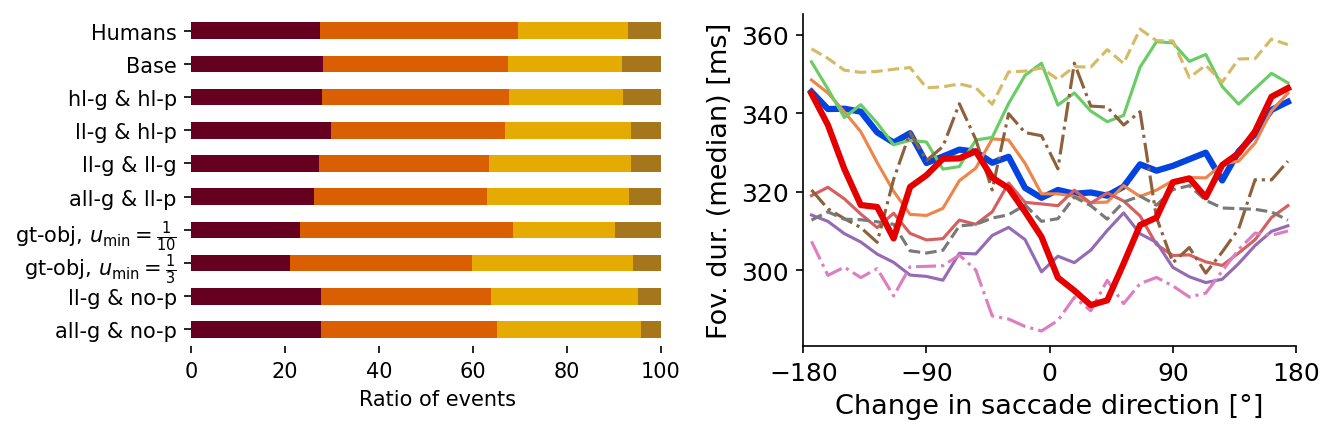

In [8]:
summary_measure='median'; ang_bins=30; sma_ws=5; obj_maxframes=90
mean_fovcats_test = []

obj_sets = ["2024-05-24-18-45-25_TEST_base_task0.0_entropy0.5_dv4.0_sig0.4",
            "2024-05-28-14-33-32_TEST_hlObj_task0.0_entropy0.5_dv4.0_sig0.4",
            "2024-05-28-14-33-34_TEST_noGlobalSAM_task0.0_entropy0.5_dv4.0_sig0.4",
            "2024-05-28-14-33-38_TEST_llPrompt_task0.0_entropy0.5_dv4.0_sig0.4",
            "2024-05-28-14-33-40_TEST_llPromptGlobalSAM_task0.0_entropy0.5_dv4.0_sig0.4",
            "2024-05-14-11-03-26_TEST_3SEC_gtObj_task0.0_entropy0.11_dv3.0_sig0.3",
            "2024-05-28-14-33-31_TEST_3SEC_gtObj_task0.0_entropy0.5_dv4.0_sig0.4",
            "2024-07-11-18-38-29_TEST_llObj_task0.0_entropy0.5_dv5.5_sig0.4",
            "2024-07-11-18-38-30_TEST_noPrompt_task0.0_entropy0.5_dv5.5_sig0.4",
           ]

obj_set_names = ["Base", "hl-g & hl-p", "ll-g & hl-p", "ll-g & ll-g", "all-g & ll-p", r"gt-obj, $u_\mathrm{min}=\frac{1}{10}$", r"gt-obj, $u_\mathrm{min}=\frac{1}{3}$", "ll-g & no-p", "all-g & no-p"]
colors = sns.color_palette("muted") # muted flare Set2 Blues

fig, axs = plt.subplots(1, 2, dpi=150, figsize=(9, 3), sharey=False)

for s_idx, s in enumerate(obj_sets):
    df_eval = pd.read_csv(os.path.join(RES_DATA_DIR, s, 'df_res_fov.csv'), index_col=0)
    x_vals, all = fovdur_vs_sacang(df_eval, ang_bins, sma_ws, summary_measure)
    if s_idx == 0:
        lw=3; c = "xkcd:blue"
    else:
        lw=1.5; c = colors[s_idx]
    # differentiate model class with linestyle
    if s_idx in [5,6]:
        ls="-."
    elif s_idx > 6:
        ls="--"
    else:
        ls="-"
    axs[1].plot(x_vals, all, color=c, label=obj_set_names[s_idx], lw=lw, ls=ls)
    bdir_ratios = np.mean(get_BDIR_per_frames(df_eval, 90), axis=1)
    mean_fovcats_test.append(bdir_ratios)
    assert round(np.sum(bdir_ratios))==100

df_gt = df_gt_all[df_gt_all["video"].isin(df_eval["video"].unique())]
x_vals, all = fovdur_vs_sacang(df_gt, ang_bins, sma_ws, summary_measure)
axs[1].plot(x_vals, all, color="xkcd:red", label="Humans", lw=3)
gt_bdir_ratios = np.mean(get_BDIR_per_frames(df_gt, 90), axis=1)

mean_fovcats_test_r = mean_fovcats_test[::-1]
df_fovcats_test = pd.DataFrame(index=obj_set_names[::-1] + ['Humans'], data= mean_fovcats_test_r + [gt_bdir_ratios])
df_fovcats_test.plot.barh(stacked=True, ax=axs[0],rot=0, legend=False, color=dircl)#.legend(bbox_to_anchor=(0.3, 1.5))
axs[0].set_frame_on(False); axs[0].set(xlabel = 'Ratio of events')#, title = 'Testset')

axs[1].set_xlabel('Change in saccade direction [°]', size=13)
axs[1].set_xlim(-180, 180)
axs[1].set_xticks([-180, -90, 0, 90, 180])
axs[1].set_ylabel(f'Fov. dur. ({summary_measure}) [ms]', size=13)
axs[1].tick_params(labelsize=12)

fig.tight_layout()
sns.despine(fig)
plt.show()


w higher influence of oncertainty (Umin=0.1) the gt obj lead to a better balance

GT obj effectively reduce the uncertainty further - uncert of 

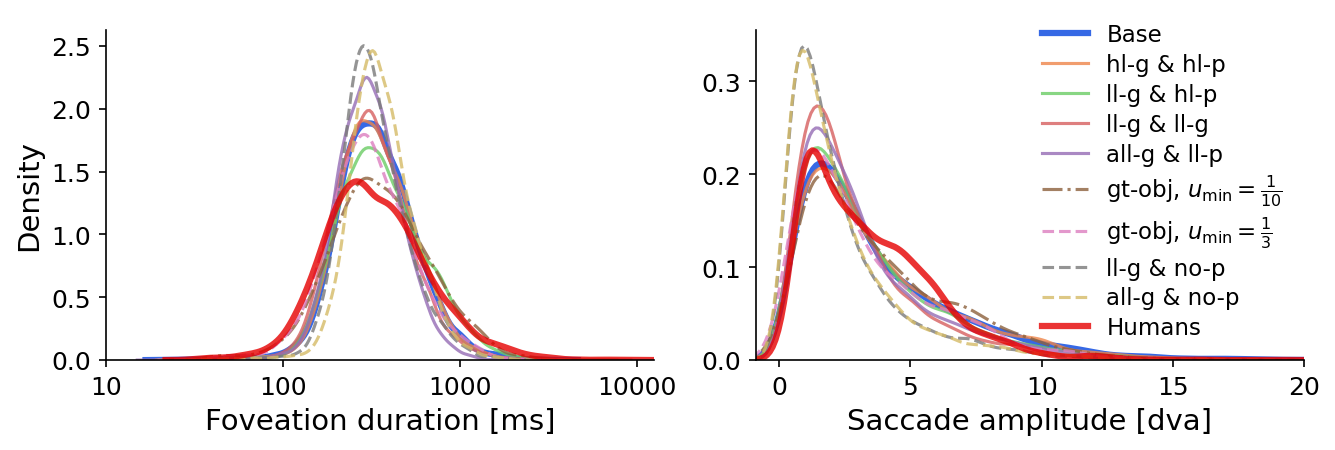

In [9]:
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(9, 3), sharey=False)
colors = sns.color_palette("muted") # muted flare Set2 Blues

for s_idx, s in enumerate(obj_sets):
    df_eval = pd.read_csv(os.path.join(RES_DATA_DIR, s, 'df_res_fov.csv'), index_col=0)
    if s_idx == 0:
        lw=3; c = "xkcd:blue"
    else:
        lw=1.5; c = colors[s_idx]
    # differentiate model class with linestyle
    if s_idx==5:
        ls="-."
    elif s_idx > 5:
        ls="--"
    else:
        ls="-"
    sns.kdeplot(np.log10(df_eval["duration_ms"].dropna().values), label=obj_set_names[s_idx], color=c, lw=lw, ls=ls, alpha=0.8, ax=axs[0])
    sns.kdeplot(df_eval["sac_amp_dva"].dropna().values, label=obj_set_names[s_idx], color=c, lw=lw, ls=ls, alpha=0.8, ax=axs[1])

df_gt = df_gt_all[df_gt_all["video"].isin(df_eval["video"].unique())]
gt_amp_dva = df_gt["sac_amp_dva"].dropna().values
gt_dur_ms = df_gt["duration_ms"].dropna().values
sns.kdeplot(np.log10(gt_dur_ms), label="Humans", color="xkcd:red", lw=3, alpha=0.8, ax=axs[0])
sns.kdeplot(gt_amp_dva, label="Humans", color="xkcd:red", lw=3, alpha=0.8, ax=axs[1])

axs[0].set_xticks([1,2,3,4])
axs[0].set_xlim([1, 4.1])
axs[0].set_xticklabels([10,100,1000,10000], size=14)
axs[0].tick_params(labelsize=12)
axs[0].set_xlabel('Foveation duration [ms]', size=14)
axs[0].set_ylabel('Density', size=14)
axs[1].set_ylabel("", size=14)
axs[1].set_xlabel('Saccade amplitude [dva]', size=14)
axs[1].tick_params(labelsize=12)
axs[1].set_xlim([-0.9, 20])
axs[1].legend(labelspacing=0.3, prop={'size':11}, frameon=False)

fig.tight_layout()
sns.despine(fig)
plt.show()

## Model extensions
### Saccadic momentum

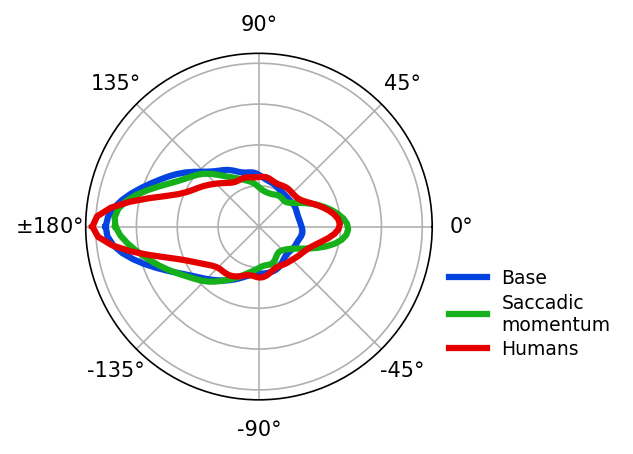

In [12]:
def plot_sac_ang_sacmo_comp(df_eval, df_sacmo, ground_truth, ang_bins=30, colors=["xkcd:blue", "xkcd:green", "xkcd:red"]):
    df_gt = ground_truth[ground_truth["video"].isin(df_eval["video"].unique())]
    dfs = [df_eval, df_sacmo, df_gt]
    labels = ["Base", "Saccadic\nmomentum", "Humans"]
    
    fig, ax = plt.subplots(1, 1, dpi=150, figsize=(3.5, 3), subplot_kw={'projection': 'polar'})
    for i, df in enumerate(dfs):
        prev_ang = df["sac_ang_p"].dropna().values
        x_p, kde_p = vonmises_kde(prev_ang / 180 * np.pi, 50)
        ax.plot(x_p, kde_p, color=colors[i], lw=3, label=labels[i])

    ax.set_xticks(ax.get_xticks()); ax.set_yticklabels([])
    ax.set_xticklabels(["0°", "45°", "90°", "135°", r"$\pm$180°   ", "-135°", "-90°", "-45°"])
    # ax.set_title('Angle relative to previous saccade')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.25), labelspacing=0.3, prop={'size':9}, frameon=False)
    plt.show()

test_sacmo_run = f"{RES_DATA_DIR}/2024-05-29-23-22-49_TEST_sacMom0.85-2.5-35deg_task0.0_entropy0.5_dv4.0_sig0.4"
df_sac_mom = pd.read_csv(f"{test_sacmo_run}/df_res_fov.csv", index_col=0)
test_base_run = f"{RES_DATA_DIR}/2024-05-24-18-45-25_TEST_base_task0.0_entropy0.5_dv4.0_sig0.4"
df_base_res = pd.read_csv(f"{test_base_run}/df_res_fov.csv", index_col=0)

plot_sac_ang_sacmo_comp(df_base_res, df_sac_mom, df_gt_all)

### Pre-saccadic attention

Base, 30: slope: 0.4725473732018238, intercept: 101.10887261020713, r_value: 0.6013957392005781, p_value: 9.425660978025653e-13, std_err: 0.05879669076273257, r2 : 0.36167683512860976
PreSac, 30: slope: 0.5649008089533428, intercept: 76.87242818613856, r_value: 0.6698416234289484, p_value: 5.987216989888037e-17, std_err: 0.05764449828491831, r2 : 0.44868780047792906
Base, 90: slope: 0.6743754343975781, intercept: 139.58476624385713, r_value: 0.7408525790110135, p_value: 1.5437086184041122e-27, std_err: 0.050087718927190765, r2 : 0.5488625438272701
PreSac, 90: slope: 0.7229927667363897, intercept: 126.61296247820769, r_value: 0.7478082123566708, p_value: 6.1944238762157905e-28, std_err: 0.052941642695280525, r2 : 0.5592171224680798


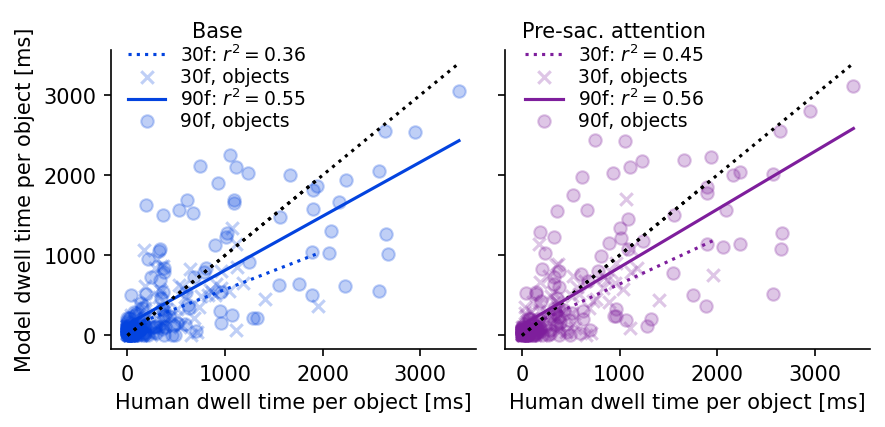

In [13]:
test_base_run = f"{RES_DATA_DIR}/2024-05-24-18-45-25_TEST_base_task0.0_entropy0.5_dv4.0_sig0.4"
df_base_res = pd.read_csv(f"{test_base_run}/df_res_fov.csv", index_col=0)
test_ps_run = f"{RES_DATA_DIR}/2024-07-25-16-16-17_TEST_preSac0.3-1.0_task0.0_entropy0.5_dv4.0_sig0.4"
df_ps_res = pd.read_csv(f"{test_ps_run}/df_res_fov.csv", index_col=0)
df_gt = df_gt_all[df_gt_all["video"].isin(df_base_res["video"].unique())]

names = ["Base", "Pre-sac. attention"]
alpha=0.25

fig, axs = plt.subplots(1, 2, dpi=150, figsize=(6, 3), sharey=True)
ls_mf = [":", "-"]
ms_mf = ["x", "o"]

for i, maxframes in enumerate([30,90]): 
    df_gt_obj = evaluate_all_obj(df_gt, prefix="gt_", maxframes=maxframes)
    # base
    df_obj = evaluate_all_obj(df_base_res, prefix="sim_", maxframes=maxframes)
    merged_df = pd.merge(df_gt_obj, df_obj, how="outer", on=['video', 'gt_object'])
    merged_df = merged_df[merged_df.gt_object != "nan"]
    merged_df = merged_df.fillna(0)
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df['gt_tot_t'], merged_df['sim_tot_t'])
    print(f"Base, {maxframes}: slope: {slope}, intercept: {intercept}, r_value: {r_value}, p_value: {p_value}, std_err: {std_err}, r2 : {r_value ** 2}")
    # axs[1].text(0.05, 0.95, r"$r^2$" + f"= {np.round(r_value ** 2, 2)}", transform=axs[1].transAxes, fontsize=10, verticalalignment='top')
    axs[0].plot([0, np.max(merged_df['gt_tot_t'])], [intercept, intercept + slope * np.max(merged_df['gt_tot_t'])], c="xkcd:blue", ls=ls_mf[i], label=f"{maxframes}f: " + r"$r^2=$" + str(round(r_value ** 2,2)))
    axs[0].scatter(merged_df['gt_tot_t'], merged_df['sim_tot_t'], marker=ms_mf[i], c="xkcd:blue", alpha=alpha, label=f"{maxframes}f, objects")
    # diagonal
    axs[0].plot([0, merged_df['gt_tot_t'].max()], [0, merged_df['gt_tot_t'].max()], ls=":", color="k")
    axs[1].plot([0, merged_df['gt_tot_t'].max()], [0, merged_df['gt_tot_t'].max()], ls=":", color="k")
    # presac
    df_obj = evaluate_all_obj(df_ps_res, prefix="sim_", maxframes=maxframes)
    merged_df = pd.merge(df_gt_obj, df_obj, how="outer", on=['video', 'gt_object'])
    merged_df = merged_df[merged_df.gt_object != "nan"]
    merged_df = merged_df.fillna(0)
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df['gt_tot_t'], merged_df['sim_tot_t'])
    print(f"PreSac, {maxframes}: slope: {slope}, intercept: {intercept}, r_value: {r_value}, p_value: {p_value}, std_err: {std_err}, r2 : {r_value ** 2}")
    # axs[1].text(0.05, 0.95, r"$r^2$" + f"= {np.round(r_value ** 2, 2)}", transform=axs[1].transAxes, fontsize=10, verticalalignment='top')
    axs[1].plot([0, np.max(merged_df['gt_tot_t'])], [intercept, intercept + slope * np.max(merged_df['gt_tot_t'])], c="xkcd:purple", ls=ls_mf[i], label=f"{maxframes}f: " + r"$r^2=$" + str(round(r_value ** 2,2)))
    axs[1].scatter(merged_df['gt_tot_t'], merged_df['sim_tot_t'], marker=ms_mf[i], c="xkcd:purple", alpha=alpha, label=f"{maxframes}f, objects")

axs[0].set_ylabel("Model dwell time per object [ms]")  # \n(mean for objects across runs)
for i, ax in enumerate(axs):
    ax.legend(loc="upper left", bbox_to_anchor=(0, 1.15), title=names[i], labelspacing=0.1, prop={'size':9}, frameon=False)
    ax.set_xlabel("Human dwell time per object [ms]")  # (mean for each object across subjects)
    ax.set_xticks([0, 1000, 2000, 3000])
    ax.set_yticks([0, 1000, 2000, 3000])
sns.despine(fig)
plt.tight_layout()
plt.show()

### Summary statistics for comparison

(2.5255370750784985, 0.29566705647227204) (2.012633780314372, 0, 1.6894791809273173)


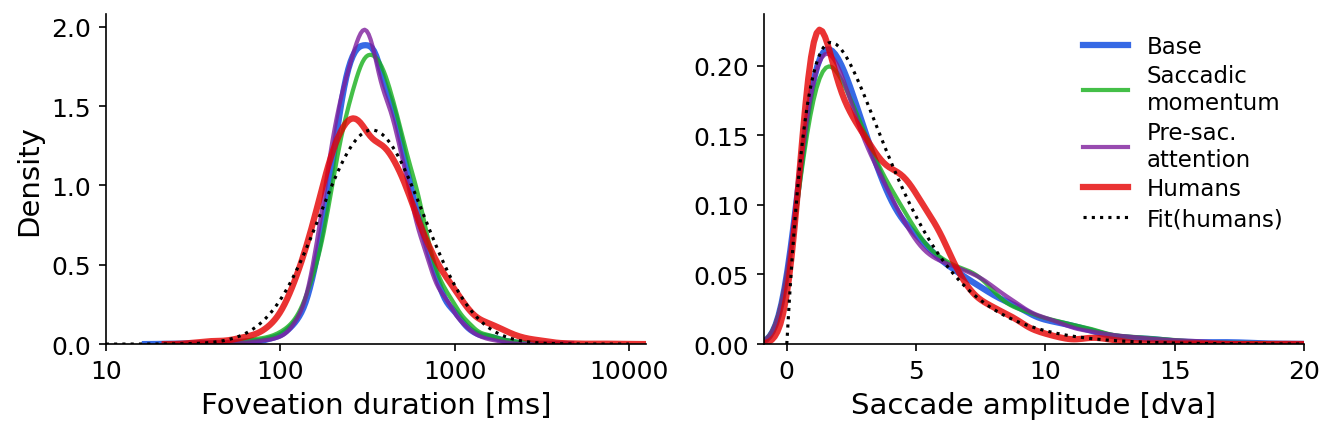

In [14]:
extension_sets = ["2024-05-24-18-45-25_TEST_base_task0.0_entropy0.5_dv4.0_sig0.4",
                  "2024-05-29-23-22-49_TEST_sacMom0.85-2.5-35deg_task0.0_entropy0.5_dv4.0_sig0.4",
                  "2024-07-25-16-16-17_TEST_preSac0.3-1.0_task0.0_entropy0.5_dv4.0_sig0.4",
                 ]

extension_set_names = ["Base", "Saccadic\nmomentum", "Pre-sac.\nattention"] #\n"+r"$(U_{const}=0.33)$
colors = ["xkcd:blue", "xkcd:green", "xkcd:purple"] 

fig, axs = plt.subplots(1, 2, dpi=150, figsize=(9, 3), sharey=False)

for s_idx, s in enumerate(extension_sets):
    df_eval = pd.read_csv(os.path.join(RES_DATA_DIR, s, 'df_res_fov.csv'), index_col=0)
    if s_idx == 0:
        lw=3
    else:
        lw=2
    sns.kdeplot(np.log10(df_eval["duration_ms"].dropna().values), label=extension_set_names[s_idx], color=colors[s_idx], lw=lw, alpha=0.8, ax=axs[0])
    sns.kdeplot(df_eval["sac_amp_dva"].dropna().values, label=extension_set_names[s_idx], color=colors[s_idx], lw=lw, alpha=0.8, ax=axs[1])

df_gt = df_gt_all[df_gt_all["video"].isin(df_eval["video"].unique())]
gt_amp_dva = df_gt["sac_amp_dva"].dropna().values
gt_dur_ms = df_gt["duration_ms"].dropna().values
sns.kdeplot(np.log10(gt_dur_ms), label="Humans", color="xkcd:red", lw=3, alpha=0.8, ax=axs[0])
sns.kdeplot(gt_amp_dva, label="Humans", color="xkcd:red", lw=3, alpha=0.8, ax=axs[1])

ampX = np.linspace(0, 20, 200)
ampfit = stats.gamma.fit(gt_amp_dva, floc=0)
ampPDF = stats.gamma.pdf(ampX, *ampfit)

durX = np.linspace(1,4, 200)
durfit = stats.norm.fit(np.log10(gt_dur_ms))
durPDF = stats.norm.pdf(durX, *durfit)
print(durfit, ampfit)

axs[0].plot(durX, durPDF, color='k', ls=':')
axs[1].plot(ampX, ampPDF, color='k', ls=':', label='Fit(humans)')

axs[0].set_xticks([1,2,3,4])
axs[0].set_xlim([1, 4.1])
axs[0].set_xticklabels([10,100,1000,10000], size=14)
axs[0].tick_params(labelsize=12)
axs[0].set_xlabel('Foveation duration [ms]', size=14)
axs[0].set_ylabel('Density', size=14)
axs[1].set_ylabel("", size=14)
axs[1].set_xlabel('Saccade amplitude [dva]', size=14)
axs[1].tick_params(labelsize=12)
axs[1].set_xlim([-0.9, 20])
axs[1].legend(labelspacing=0.3, prop={'size':11}, frameon=False)

fig.tight_layout()
sns.despine(fig)
plt.show()

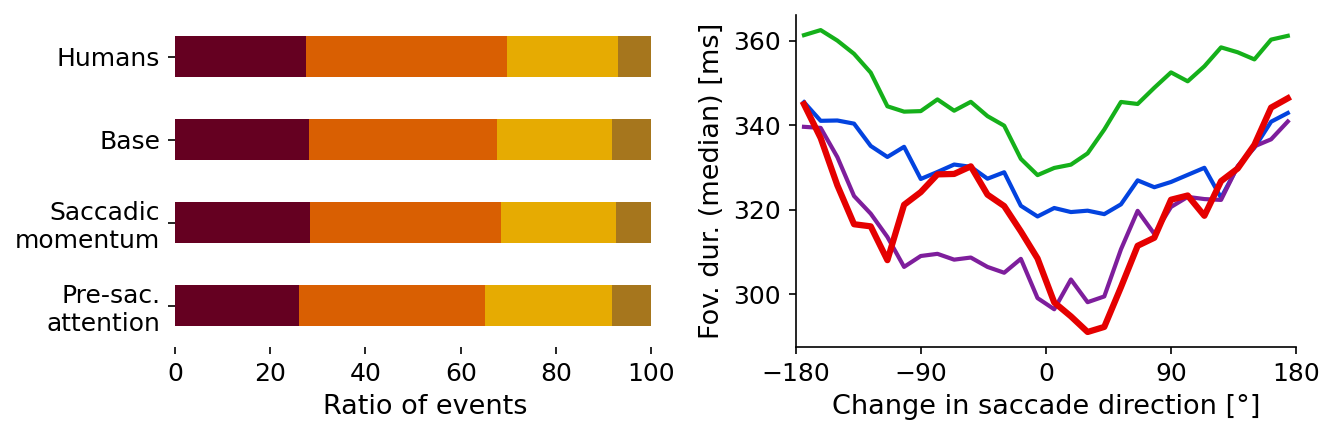

In [15]:
dircl = ["xkcd:maroon", sns.color_palette("Dark2")[1], sns.color_palette("Dark2")[5], sns.color_palette("Dark2")[6]]

summary_measure='median'; ang_bins=30; sma_ws=5; obj_maxframes=90
mean_fovcats_test = []

fig, axs = plt.subplots(1, 2, dpi=150, figsize=(9, 3), sharey=False)

for s_idx, s in enumerate(extension_sets):
    df_eval = pd.read_csv(os.path.join(RES_DATA_DIR, s, 'df_res_fov.csv'), index_col=0)
    if s_idx == 3:
        lw=3; c = "xkcd:blue"
    else:
        lw=2; c = colors[s_idx]
    x_vals, all = fovdur_vs_sacang(df_eval, ang_bins, sma_ws, summary_measure)
    axs[1].plot(x_vals, all, color=c, label=extension_set_names[s_idx], lw=lw)
    bdir_ratios = np.mean(get_BDIR_per_frames(df_eval, 90), axis=1)
    mean_fovcats_test.append(bdir_ratios)
    assert round(np.sum(bdir_ratios))==100

df_gt = df_gt_all[df_gt_all["video"].isin(df_eval["video"].unique())]
x_vals, all = fovdur_vs_sacang(df_gt, ang_bins, sma_ws, summary_measure)
axs[1].plot(x_vals, all, color="xkcd:red", label="Humans", lw=3)
gt_bdir_ratios = np.mean(get_BDIR_per_frames(df_gt, 90), axis=1)

mean_fovcats_test_r = mean_fovcats_test[::-1]
df_fovcats_test = pd.DataFrame(index=extension_set_names[::-1] + ['Humans'], data= mean_fovcats_test_r + [gt_bdir_ratios])
df_fovcats_test.plot.barh(stacked=True, ax=axs[0],rot=0, legend=False, color=dircl)#.legend(bbox_to_anchor=(0.3, 1.5))
axs[0].set_frame_on(False)
axs[0].set_xlabel('Ratio of events', size=13)#, title = 'Testset')
axs[0].tick_params(labelsize=12)

axs[1].set_xlabel('Change in saccade direction [°]', size=13)
axs[1].set_xlim(-180, 180)
# axs[0].set_yticks([200, 300, 400, 500, 600])
axs[1].set_xticks([-180, -90, 0, 90, 180])
axs[1].set_ylabel(f'Fov. dur. ({summary_measure}) [ms]', size=13)
axs[1].tick_params(labelsize=12)

fig.tight_layout()
sns.despine(fig)
plt.show()


### Bonus: Which object is foveated first?

In [19]:
extension_sets = ["2024-05-24-18-45-25_TEST_base_task0.0_entropy0.5_dv4.0_sig0.4",
                  "2024-05-29-23-22-49_TEST_sacMom0.85-2.5-35deg_task0.0_entropy0.5_dv4.0_sig0.4",
                  "2024-07-25-16-16-17_TEST_preSac0.3-1.0_task0.0_entropy0.5_dv4.0_sig0.4",
                 ]

extension_set_names = ["Base", "Saccadic\nmomentum", "Pre-sac.\nattention"] #\n"+r"$(U_{const}=0.33)$


In [20]:
df_gt = df_gt_all[df_gt_all["video"].isin(df_eval["video"].unique())]

df_only_obj = df_gt[df_gt['gt_object'].notna()]
df_only_obj = df_only_obj[df_only_obj['gt_object'].str.startswith("Obj")]
first_occurrences = df_only_obj.groupby(['video', 'subject'])['gt_object'].first().reset_index()
df_fo_gt = first_occurrences.groupby('video')['gt_object'].value_counts().unstack().fillna(0).reset_index()
df_fo_gt.sort_values("video", inplace=True)
df_fo_gt

gt_object,video,Object 1,Object 10,Object 11,Object 12,Object 2,Object 23,Object 3,Object 4,Object 5,Object 6,Object 7,Object 8,Object 9
0,--Kr1PZaPDI,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0IEt9-NeV4,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2kJpg1NIzM,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
3,-53DvfE42gE,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-6HHK4EV5yU,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-Cf0liD1olk,7.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-DgC31LRuXs,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-FmHMTNzAJY,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-Gfncisg2GE,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-PMG_RNHaQE,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0


In [21]:
winner_df = pd.DataFrame()
object_columns = [col for col in df_fo_gt.columns if col.startswith("Obj")]
df_fo_gt['winner'] = df_fo_gt[object_columns].idxmax(axis=1)
winner_df["video"] = df_fo_gt['video']
winner_df["GT"] = df_fo_gt['winner']

for s_idx, s in enumerate(extension_sets):
    df_eval = pd.read_csv(os.path.join(RES_DATA_DIR, s, 'df_res_fov.csv'), index_col=0)
    df_only_obj = df_eval[df_eval['gt_object'].notna()]
    df_only_obj = df_only_obj[df_only_obj['gt_object'].str.startswith("Obj")]
    first_occurrences = df_only_obj.groupby(['video', 'subject'])['gt_object'].first().reset_index()
    df_fo_eval = first_occurrences.groupby('video')['gt_object'].value_counts().unstack().fillna(0).reset_index()
    object_columns = [col for col in df_fo_eval.columns if col.startswith("Obj")]
    missing_videos = df_fo_gt['video'][~df_fo_gt['video'].isin(df_fo_eval['video'])]
    if len(missing_videos)>0:
        print(s)
        print(missing_videos)
        new_rows = pd.DataFrame(0, index=missing_videos.index, columns=df_fo_eval.columns)
        new_rows['video'] = missing_videos.values
        df_fo_eval = pd.concat([df_fo_eval, new_rows], ignore_index=True)
    df_fo_eval.sort_values("video", inplace=True)
    df_fo_eval['winner'] = df_fo_eval[object_columns].idxmax(axis=1)
    # print(f"_____________\n{s}")
    # print(df_fo_eval)
    winner_df[extension_set_names[s_idx]] = df_fo_eval['winner'].values

winner_df



,video,GT,Base,Saccadic\nmomentum,Pre-sac.\nattention
0,--Kr1PZaPDI,Object 1,Object 1,Object 1,Object 1
1,-0IEt9-NeV4,Object 1,Object 1,Object 1,Object 1
2,-2kJpg1NIzM,Object 1,Object 1,Object 1,Object 1
3,-53DvfE42gE,Object 2,Object 2,Object 2,Object 2
4,-6HHK4EV5yU,Object 1,Object 1,Object 1,Object 1
5,-Cf0liD1olk,Object 1,Object 1,Object 1,Object 1
6,-DgC31LRuXs,Object 1,Object 1,Object 1,Object 1
7,-FmHMTNzAJY,Object 1,Object 1,Object 1,Object 1
8,-Gfncisg2GE,Object 1,Object 1,Object 1,Object 1
9,-PMG_RNHaQE,Object 4,Object 2,Object 2,Object 4


In [22]:
print(len(winner_df.loc[winner_df["GT"] == winner_df["Pre-sac.\nattention"]]))
print(len(winner_df.loc[winner_df["GT"] == winner_df["Pre-sac.\nattention"]])/len(winner_df)*100)

25
75.75757575757575


In [23]:
print(len(winner_df.loc[winner_df["GT"] == winner_df["Base"]]))
print(len(winner_df.loc[winner_df["GT"] == winner_df["Base"]])/len(winner_df)*100)

24
72.72727272727273
